# Unsupervised anomaly detection (fraud) algorithm

First data cleaning (exclusions, imputation) is done, then variables are built that are designed to look for the kinds of anomalies such as unusual property valuations.

To remove correlations and reduce dimensionality, PCA is performed. We z scale, do PCA, keep the top PCs, then z scale again in order to make each retained PC equally important, optionally to compare performance.

Two different anomaly detection (fraud) algorithms are used. The first one looks for outliers in the final scaled PC space using a Minkowski distance from the origin. The second method makes a autoencoder and the fraud score is the reproduction error.

The scores are averaged by replacing the score with its rank order and then average the rank-ordered scores for our final score.

Finally all the records are sorted by this final score and the top n records are explored. To help the investigation, the variables driving these top scoring records are shown with a heat map of the variable zscores, which can point the investigators to what's making the high score for these top scoring records.

The data can be found here: https://data.cityofnewyork.us/Housing-Development/Property-Valuation-and-Assessment-Data/rgy2-tti8

In [1]:
from datetime import datetime
start_time = datetime.now()

from sklearn.neural_network import MLPRegressor
import pandas as pd
import numpy as np
import scipy.stats as sps
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
%matplotlib inline

print('LOAD DURATION:',datetime.now() - start_time) # about 6 seconds

LOAD DURATION: 0:00:01.617460


In [2]:
%%time
data = pd.read_csv('NY property data.csv')
NY_data_orig = data.copy()
data.shape

CPU times: user 3.96 s, sys: 970 ms, total: 4.93 s
Wall time: 5.53 s


(1070994, 32)

In [3]:
data.dtypes

RECORD        int64
BBLE         object
BORO          int64
BLOCK         int64
LOT           int64
EASEMENT     object
OWNER        object
BLDGCL       object
TAXCLASS     object
LTFRONT       int64
LTDEPTH       int64
EXT          object
STORIES     float64
FULLVAL     float64
AVLAND      float64
AVTOT       float64
EXLAND      float64
EXTOT       float64
EXCD1       float64
STADDR       object
ZIP         float64
EXMPTCL      object
BLDFRONT      int64
BLDDEPTH      int64
AVLAND2     float64
AVTOT2      float64
EXLAND2     float64
EXTOT2      float64
EXCD2       float64
PERIOD       object
YEAR         object
VALTYPE      object
dtype: object

In [4]:
data.head()

,RECORD,BBLE,BORO,BLOCK,LOT,EASEMENT,OWNER,BLDGCL,TAXCLASS,LTFRONT,...,BLDFRONT,BLDDEPTH,AVLAND2,AVTOT2,EXLAND2,EXTOT2,EXCD2,PERIOD,YEAR,VALTYPE
0,1,1000010101,1,1,101,NaN,U S GOVT LAND & BLDGS,P7,4,500,...,0,0,3775500.0,8613000.0,3775500.0,8613000.0,NaN,FINAL,2010/11,AC-TR
1,2,1000010201,1,1,201,NaN,U S GOVT LAND & BLDGS,Z9,4,27,...,0,0,11111400.0,80690400.0,11111400.0,80690400.0,NaN,FINAL,2010/11,AC-TR
2,3,1000020001,1,2,1,NaN,DEPT OF GENERAL SERVI,Y7,4,709,...,709,564,32321790.0,40179510.0,32321790.0,40179510.0,NaN,FINAL,2010/11,AC-TR
3,4,1000020023,1,2,23,NaN,DEPARTMENT OF BUSINES,T2,4,793,...,85,551,13644000.0,15750000.0,13644000.0,15750000.0,NaN,FINAL,2010/11,AC-TR
4,5,1000030001,1,3,1,NaN,PARKS AND RECREATION,Q1,4,323,...,89,57,106348680.0,107758350.0,106348680.0,107758350.0,NaN,FINAL,2010/11,AC-TR


## Remove some benign properties that we aren't interested in
There are certainly better ways to do this, and this important step can/should be improved.

In [5]:
#look at the most frequent owners
remove_list = data['OWNER'].value_counts().head(500).index.tolist()
remove_list

['PARKCHESTER PRESERVAT',
 'PARKS AND RECREATION',
 'DCAS',
 'HOUSING PRESERVATION',
 'CITY OF NEW YORK',
 'DEPT OF ENVIRONMENTAL',
 'BOARD OF EDUCATION',
 'NEW YORK CITY HOUSING',
 'CNY/NYCTA',
 'NYC HOUSING PARTNERSH',
 'YORKVILLE TOWERS ASSO',
 'DEPARTMENT OF BUSINES',
 'DEPT OF TRANSPORTATIO',
 'MTA/LIRR',
 'PARCKHESTER PRESERVAT',
 'MH RESIDENTIAL 1, LLC',
 '434 M LLC',
 'LINCOLN PLAZA ASSOCIA',
 'DEUTSCHE BANK NATIONA',
 '561 11TH AVENUE TMG L',
 'OCEAN SHELL LLC',
 'CPW TOWERS',
 'DORCHESTER ASSOCIATES',
 'PM PARTNERS',
 '99 JOHN ST.,LLC',
 'NEW YORK CITY TRANSIT',
 'FIRE DEPARTMENT',
 'TRUSTEES OF COLUMBIA',
 'DEPT OF GENERAL SERVI',
 'BRIGHTWATER TOWERS',
 'NEW YORK STATE OWNED',
 'POLICE DEPARTMENT',
 'JOINTLY OWNED PLAYGRO',
 'NYC HOUSING AUTHORITY',
 'THE CITY OF NEW YORK',
 'NYC PARTNERSHIP HOUSI',
 'S.K.I. REALTY, INC.',
 'GRENADIER REALTY CORP',
 'DEPT RE-CITY OF NY',
 'NY STATE PUBLIC SERV',
 'YESHIVA UNIVERSITY',
 '301 66 OWNERS CORP',
 'EL AD US I, LLC',
 'LIRR',
 'WI

In [6]:
#from collections import Counter

#word_counts = Counter()
#for phrase in remove_list:
   # words = phrase.split()
    #for word in words:
        #if word.lower() not in ['and', 'of', 'the', 'in', 'to', 'for', 'at', 'with', 'on', 'from', 'a']:
           # word_counts[word] += 1

#top_words = word_counts.most_common(10)
#print(top_words)


In [7]:
import pandas as pd


keywords = ['NYC', 'NEW', 'YORK', 'DEPT','STATE OF NEW YORK','PUBLIC SERV', 'BOARD', 'GOVT OWNED', 'CNY', 'PRESERVATION', 'PARKS' , 'PARK', 'GOVERNMENT', 'NATIONAL', 'DEPARTMENT', 'CITY', 'N.Y.C.', 'N.Y.', 'N.Y.C', 'N.Y', 'YORK CITY', 'NYS', 'NYS DEPT','NEW YORK CITY']

owner_list = []

for index, row in data.iterrows():
    if any(keyword in str(row['OWNER']).upper() for keyword in keywords):
        owner_list.append(row['OWNER'])


In [8]:
property_data = data[~data['OWNER'].isin(owner_list)].reset_index(drop=True)
property_data.shape

(1036009, 32)

In [9]:
data.shape

(1070994, 32)

In [10]:

len(data) - len(property_data)

34985

In [11]:
numrecs = len(property_data)

## Fill in missing ZIP

In [12]:
missing_zips = np.where(pd.isnull(property_data['ZIP']))[0]
len(missing_zips)

21305

In [13]:
for i in range(len(missing_zips)):
    if(property_data.loc[missing_zips[i]+1,'ZIP'] == property_data.loc[missing_zips[i]-1,'ZIP']):
        property_data.loc[missing_zips[i],'ZIP'] = property_data.loc[missing_zips[i]-1,'ZIP']

In [14]:
missing_zips = np.where(pd.isnull(property_data['ZIP']))[0]
len(missing_zips)

9955

In [15]:
for i in range(len(missing_zips)):
    property_data.loc[missing_zips[i],'ZIP'] = property_data.loc[missing_zips[i]-1,'ZIP']

In [16]:
missing_zips = np.where(pd.isnull(property_data['ZIP']))[0]
len(missing_zips)

0

In [17]:
property_data.to_csv('NY_Data.csv')

## Calculate means for AVTOT, AVLAND, FULLVAL by taxclass, avoiding the records with zeros

In [19]:
#filtering out zero values for building and lot dimensions
df_filtered = property_data[property_data['BLDFRONT'] != 0 ]
df_filtered = df_filtered[property_data['BLDDEPTH'] != 0 ]
df_filtered = df_filtered[property_data['LTFRONT'] != 0 ]
df_filtered = df_filtered[property_data['LTDEPTH'] != 0 ]

/var/folders/k_/qj9g84_n20qbv9c334qzl7p00000gn/T/ipykernel_18476/2193234182.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_filtered = df_filtered[property_data['BLDDEPTH'] != 0 ]
/var/folders/k_/qj9g84_n20qbv9c334qzl7p00000gn/T/ipykernel_18476/2193234182.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_filtered = df_filtered[property_data['LTFRONT'] != 0 ]
/var/folders/k_/qj9g84_n20qbv9c334qzl7p00000gn/T/ipykernel_18476/2193234182.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_filtered = df_filtered[property_data['LTDEPTH'] != 0 ]


In [20]:
#Calculating Floor to area ratio
df_filtered['FAR']=((df_filtered['BLDFRONT']*df_filtered['BLDDEPTH']*df_filtered['STORIES'])/(df_filtered['LTFRONT']*df_filtered['LTDEPTH']))
df_filtered['BLDAREA']=df_filtered['BLDFRONT']*df_filtered['BLDDEPTH']
df_filtered['LTAREA']=df_filtered['LTFRONT']*df_filtered['LTDEPTH']
    

In [21]:
temp_far = df_filtered[df_filtered['FAR']!=0]
zip_far = temp_far.groupby('ZIP')['FAR'].mean()
zip_far.astype('int64', copy=False)

ZIP
10001.0     7
10002.0     4
10003.0     4
10004.0    15
10005.0    21
           ..
11692.0     0
11693.0     0
11694.0     0
11695.0     0
11697.0     0
Name: FAR, Length: 190, dtype: int64

In [22]:
temp_ltarea = df_filtered[df_filtered['LTAREA']!=0]
zip_ltarea = temp_far.groupby('ZIP')['LTAREA'].mean()
zip_ltarea

ZIP
10001.0      9215.809000
10002.0      5180.657980
10003.0      4272.383803
10004.0     12493.489130
10005.0     18364.250000
               ...      
11692.0      5436.393228
11693.0      6118.740025
11694.0      5298.143697
11695.0    403430.000000
11697.0    600035.800000
Name: LTAREA, Length: 190, dtype: float64

In [23]:
temp_bldarea = df_filtered[df_filtered['BLDAREA']!=0]
zip_bldarea = temp_far.groupby('ZIP')['BLDAREA'].mean()
zip_bldarea

ZIP
10001.0     6968.737000
10002.0     2973.831922
10003.0     3487.912559
10004.0    11622.413043
10005.0    16692.083333
               ...     
11692.0     1541.440197
11693.0     1170.840399
11694.0     1278.676190
11695.0     1137.500000
11697.0     2102.800000
Name: BLDAREA, Length: 190, dtype: float64

In [24]:
zip_stories = (zip_far*zip_ltarea)/zip_bldarea

In [25]:
property_data['FULLVAL'].replace('NaN',0)
temp =property_data[property_data['FULLVAL']!=0]
mean_fullval = temp.groupby('TAXCLASS')['FULLVAL'].mean()
print(mean_fullval)

TAXCLASS
1     5.695831e+05
1A    3.351950e+05
1B    4.087149e+05
1C    7.631702e+05
1D    3.240683e+07
2     7.594880e+05
2A    8.632616e+05
2B    1.254830e+06
2C    7.667854e+05
3     8.578186e+04
4     2.592087e+06
Name: FULLVAL, dtype: float64


In [26]:
property_data['AVLAND'].replace('NaN',0)
temp_avland = property_data[property_data['AVLAND']!=0]
mean_avland = temp_avland.groupby('TAXCLASS')['AVLAND'].mean()

In [27]:
property_data['AVTOT'].replace('NaN',0)
temp_avtot = property_data[property_data['AVTOT']!=0]
mean_avtot = temp_avtot.groupby('TAXCLASS')['AVTOT'].mean()

## Substituting decent values for AVTOT, AVLAND, FULLVAL from averages by taxclass

In [28]:
%%time
for index in mean_fullval.index:
    property_data.loc[(property_data['FULLVAL']==0)&(property_data['TAXCLASS']==index),'FULLVAL']=mean_fullval[index]
    property_data.loc[(property_data['AVLAND']==0)&(property_data['TAXCLASS']==index),'AVLAND']=mean_avland[index]
    property_data.loc[(property_data['AVTOT']==0)&(property_data['TAXCLASS']==index),'AVTOT']=mean_avtot[index]

CPU times: user 1.86 s, sys: 65 ms, total: 1.93 s
Wall time: 1.92 s


In [29]:
property_data.head().transpose()

,0,1,2,3,4
RECORD,1,2,9,10,11
BBLE,1000010101,1000010201,1000041001,1000041002,1000041003
BORO,1,1,1,1,1
BLOCK,1,1,4,4,4
LOT,101,201,1001,1002,1003
EASEMENT,NaN,NaN,NaN,NaN,NaN
OWNER,U S GOVT LAND & BLDGS,U S GOVT LAND & BLDGS,"TRZ HOLDINGS, LLC","TRZ HOLDINGS, LLC","TRZ HOLDINGS, LLC"
BLDGCL,P7,Z9,R5,R5,R5
TAXCLASS,4,4,4,4,4
LTFRONT,500,27,0,0,0


## Fill in the missing STORIES

In [30]:
temp = property_data[property_data['STORIES'].isnull()]
len(temp)

42619

In [31]:
mean_stories = property_data.groupby('TAXCLASS')['STORIES'].mean()
print(mean_stories)

TAXCLASS
1      2.111093
1A     1.656396
1B     4.000000
1C     3.053029
1D     1.055556
2     16.332413
2A     2.842397
2B     3.997937
2C     4.747957
3      1.000000
4      5.424300
Name: STORIES, dtype: float64


In [32]:
temp.head().transpose()

,0,1,58,59,60
RECORD,1,2,66,67,68
BBLE,1000010101,1000010201,1000051004,1000051005,1000051006
BORO,1,1,1,1,1
BLOCK,1,1,5,5,5
LOT,101,201,1004,1005,1006
EASEMENT,NaN,NaN,NaN,NaN,NaN
OWNER,U S GOVT LAND & BLDGS,U S GOVT LAND & BLDGS,SLG BROAD STREET 125,AMERICAN CIVIL LIBERT,SLG BROAD STREET 125
BLDGCL,P7,Z9,R5,R5,R5
TAXCLASS,4,4,4,4,4
LTFRONT,500,27,0,0,0


In [33]:
len(property_data[property_data["STORIES"]==0])

0

In [34]:
#Using FAR to fill missing stories entries
property_data['STORIES']=property_data['STORIES'].fillna(value =0)
for index in zip_stories.index:
    property_data.loc[(property_data['STORIES']==0)&(property_data['ZIP']==index),'STORIES']=zip_stories[index]
print(len(property_data[property_data["STORIES"]==0]))
for index in mean_stories.index:
    property_data.loc[(property_data['STORIES']==0)&(property_data['TAXCLASS']==index),'STORIES']=mean_stories[index]
print(len(property_data[property_data["STORIES"]==0]))

5
0


In [35]:
property_data.head().transpose()

,0,1,2,3,4
RECORD,1,2,9,10,11
BBLE,1000010101,1000010201,1000041001,1000041002,1000041003
BORO,1,1,1,1,1
BLOCK,1,1,4,4,4
LOT,101,201,1001,1002,1003
EASEMENT,NaN,NaN,NaN,NaN,NaN
OWNER,U S GOVT LAND & BLDGS,U S GOVT LAND & BLDGS,"TRZ HOLDINGS, LLC","TRZ HOLDINGS, LLC","TRZ HOLDINGS, LLC"
BLDGCL,P7,Z9,R5,R5,R5
TAXCLASS,4,4,4,4,4
LTFRONT,500,27,0,0,0


## Fill in LTFRONT, LTDEPTH, BLDDEPTH, BLDFRONT with averages by TAXCLASS

In [36]:
temp=property_data[property_data['LTFRONT']==0]
#temp=temp[temp['LTDEPTH']!=0]
#for index in zip_ltarea.index:
    #temp.loc[(temp['LTFRONT']==0)&(temp['ZIP']==index),'LTFRONT']=(zip_ltarea[index]/temp.loc[(temp['LTFRONT']==0)&(temp['ZIP']==index),'LTDEPTH'])

In [37]:
print(len(temp[temp["LTDEPTH"]!=0]))

200


In [38]:
# Because these 4 fields do not have NAs, replacing 0s. 
# Since zero and 1 are invalid values for these fields, so replace them with NA.
# Calculating groupwise average. Replacing 0 and 1's by NAs so they are not counted in calculating mean.
property_data.loc[property_data['LTFRONT']==0,'LTFRONT']=np.nan
property_data.loc[property_data['LTDEPTH']==0,'LTDEPTH']=np.nan
property_data.loc[property_data['BLDFRONT']==0,'BLDFRONT']=np.nan
property_data.loc[property_data['BLDDEPTH']==0,'BLDDEPTH']=np.nan
property_data.loc[property_data['LTFRONT']==1,'LTFRONT']=np.nan
property_data.loc[property_data['LTDEPTH']==1,'LTDEPTH']=np.nan
property_data.loc[property_data['BLDFRONT']==1,'BLDFRONT']=np.nan
property_data.loc[property_data['BLDDEPTH']==1,'BLDDEPTH']=np.nan

# Calculate mean
mean_LTFRONT=property_data.groupby(property_data['TAXCLASS'])['LTFRONT'].mean()
mean_LTDEPTH=property_data.groupby(property_data['TAXCLASS'])['LTDEPTH'].mean()
mean_BLDFRONT=property_data.groupby(property_data['TAXCLASS'])['BLDFRONT'].mean()
mean_BLDDEPTH=property_data.groupby(property_data['TAXCLASS'])['BLDDEPTH'].mean()

#impute values with the average for that record's TAXCLASS
for index in mean_LTFRONT.index:
    property_data.loc[(property_data['LTFRONT'].isnull())&(property_data['TAXCLASS']==index),'LTFRONT']=mean_LTFRONT[index]    
    property_data.loc[(property_data['LTDEPTH'].isnull())&(property_data['TAXCLASS']==index),'LTDEPTH']=mean_LTDEPTH[index]
    property_data.loc[(property_data['BLDFRONT'].isnull())&(property_data['TAXCLASS']==index),'BLDFRONT']=mean_BLDFRONT[index]
    property_data.loc[(property_data['BLDDEPTH'].isnull())&(property_data['TAXCLASS']==index),'BLDDEPTH']=mean_BLDDEPTH[index]

In [39]:
mean_LTFRONT

TAXCLASS
1      30.937975
1A     50.979863
1B     46.701107
1C     27.305648
1D    428.055556
2     111.134502
2A     25.916268
2B     27.187887
2C     30.075555
3     148.644790
4      81.243611
Name: LTFRONT, dtype: float64

In [40]:
mean_LTDEPTH

TAXCLASS
1      99.278558
1A     89.134080
1B    104.617781
1C     96.797342
1D    578.777778
2     130.515970
2A     97.304892
2B     95.722337
2C     95.641719
3     341.657414
4     123.038975
Name: LTDEPTH, dtype: float64

In [41]:
mean_BLDFRONT

TAXCLASS
1     21.402802
1A    24.940520
1B    39.500000
1C    23.402390
1D    20.055556
2     91.639693
2A    22.986423
2B    25.983586
2C    27.939277
3     10.000000
4     61.135801
Name: BLDFRONT, dtype: float64

In [42]:
mean_BLDDEPTH

TAXCLASS
1      41.559049
1A     44.543027
1B     82.666667
1C     60.143426
1D     35.833333
2     108.044544
2A     62.454437
2B     66.479949
2C     68.785437
3      15.000000
4      85.326711
Name: BLDDEPTH, dtype: float64

In [43]:
data = property_data.copy()
data.shape

(1036009, 32)

In [44]:
data.dtypes

RECORD        int64
BBLE         object
BORO          int64
BLOCK         int64
LOT           int64
EASEMENT     object
OWNER        object
BLDGCL       object
TAXCLASS     object
LTFRONT     float64
LTDEPTH     float64
EXT          object
STORIES     float64
FULLVAL     float64
AVLAND      float64
AVTOT       float64
EXLAND      float64
EXTOT       float64
EXCD1       float64
STADDR       object
ZIP         float64
EXMPTCL      object
BLDFRONT    float64
BLDDEPTH    float64
AVLAND2     float64
AVTOT2      float64
EXLAND2     float64
EXTOT2      float64
EXCD2       float64
PERIOD       object
YEAR         object
VALTYPE      object
dtype: object

In [45]:
data['ZIP'] = data['ZIP'].astype(str)
data['zip3'] = data['ZIP'].str[:3]

In [46]:
data.count()

RECORD      1036009
BBLE        1036009
BORO        1036009
BLOCK       1036009
LOT         1036009
EASEMENT       1706
OWNER       1004264
BLDGCL      1036009
TAXCLASS    1036009
LTFRONT     1036009
LTDEPTH     1036009
EXT          351978
STORIES     1036009
FULLVAL     1036009
AVLAND      1036009
AVTOT       1036009
EXLAND      1036009
EXTOT       1036009
EXCD1        618991
STADDR      1035659
ZIP         1036009
EXMPTCL        8778
BLDFRONT    1036009
BLDDEPTH    1036009
AVLAND2      260300
AVTOT2       260306
EXLAND2       78752
EXTOT2       115293
EXCD2         92435
PERIOD      1036009
YEAR        1036009
VALTYPE     1036009
zip3        1036009
dtype: int64

In [47]:
cols = data.columns
print(cols)

Index(['RECORD', 'BBLE', 'BORO', 'BLOCK', 'LOT', 'EASEMENT', 'OWNER', 'BLDGCL',
       'TAXCLASS', 'LTFRONT', 'LTDEPTH', 'EXT', 'STORIES', 'FULLVAL', 'AVLAND',
       'AVTOT', 'EXLAND', 'EXTOT', 'EXCD1', 'STADDR', 'ZIP', 'EXMPTCL',
       'BLDFRONT', 'BLDDEPTH', 'AVLAND2', 'AVTOT2', 'EXLAND2', 'EXTOT2',
       'EXCD2', 'PERIOD', 'YEAR', 'VALTYPE', 'zip3'],
      dtype='object')


### Now build variables that try to find properties that are unusual in ways we're interested in

In [48]:
data['ltsize'] = data['LTFRONT'] * data['LTDEPTH']
data['bldsize'] = data['BLDFRONT'] * data['BLDDEPTH']
data['bldvol'] = data['bldsize'] * data['STORIES']

In [49]:
data['r1'] = data['FULLVAL'] / data['ltsize']
data['r2'] = data['FULLVAL'] / data['bldsize']
data['r3'] = data['FULLVAL'] / data['bldvol']
data['r4'] = data['AVLAND'] / data['ltsize']
data['r5'] = data['AVLAND'] / data['bldsize']
data['r6'] = data['AVLAND'] / data['bldvol']
data['r7'] = data['AVTOT'] / data['ltsize']
data['r8'] = data['AVTOT'] / data['bldsize']
data['r9'] = data['AVTOT'] / data['bldvol']

In [50]:
# Calculate total acreage for each ZIP code
acreage = data.groupby('ZIP').apply(lambda x: (x['LTFRONT'] * x['LTDEPTH']).sum() / 43560)

# Merge acreage back into original DataFrame
data = data.merge(acreage.rename('TOTALACREAGE'), on='ZIP')

In [51]:
# add in the inverse of all the 9 primary variables
epsilon = .01
for col in data.columns[36:]:
    data[col+'inv'] = 1/(data[col] + epsilon)

In [52]:
vars1 = ['TOTALACREAGE', 'TOTALACREAGEinv']
taxclass_mean = data.groupby('TAXCLASS')[vars1].mean()
data = data.join(taxclass_mean, on='TAXCLASS', rsuffix='_taxclass')

rsuffix = ['_taxclass']
for var in vars1:
    for r in rsuffix:
        data[str(var)+r] = data[var] / data[str(var)+r]

In [53]:
vars18 = ['r1','r2','r3','r4','r5','r6','r7','r8','r9',
          'r1inv','r2inv','r3inv','r4inv','r5inv','r6inv','r7inv','r8inv','r9inv']
zip5_mean = data.groupby('ZIP')[vars18].mean()
taxclass_mean = data.groupby('TAXCLASS')[vars18].mean()
data = data.join(zip5_mean, on='ZIP', rsuffix='_zip5')
data = data.join(taxclass_mean, on='TAXCLASS', rsuffix='_taxclass')
rsuffix = ['_zip5', '_taxclass']
for var in vars18:
    for r in rsuffix:
        data[str(var)+r] = data[var] / data[str(var)+r]

In [54]:
data['value_ratio'] = data['FULLVAL']/(data['AVLAND']+data['AVTOT'])
data['value_ratio'] = data['value_ratio']/data['value_ratio'].mean()
data['value_ratio'] = np.where(data['value_ratio'] < 1, 1/(data['value_ratio']+epsilon), data['value_ratio'])

In [55]:
data.head().transpose()

,0,1,2,3,4
RECORD,1,2,9,10,11
BBLE,1000010101,1000010201,1000041001,1000041002,1000041003
BORO,1,1,1,1,1
BLOCK,1,1,4,4,4
LOT,101,201,1001,1002,1003
...,...,...,...,...,...
r6inv_taxclass,0.00303,0.000895,0.059456,0.041193,0.039145
r7inv_taxclass,0.069311,0.000049,0.00719,0.004975,0.002676
r8inv_taxclass,0.000927,0.000102,0.005028,0.003479,0.001871
r9inv_taxclass,0.003001,0.000331,0.048212,0.033375,0.017958


In [56]:
data.columns

Index(['RECORD', 'BBLE', 'BORO', 'BLOCK', 'LOT', 'EASEMENT', 'OWNER', 'BLDGCL',
       'TAXCLASS', 'LTFRONT', 'LTDEPTH', 'EXT', 'STORIES', 'FULLVAL', 'AVLAND',
       'AVTOT', 'EXLAND', 'EXTOT', 'EXCD1', 'STADDR', 'ZIP', 'EXMPTCL',
       'BLDFRONT', 'BLDDEPTH', 'AVLAND2', 'AVTOT2', 'EXLAND2', 'EXTOT2',
       'EXCD2', 'PERIOD', 'YEAR', 'VALTYPE', 'zip3', 'ltsize', 'bldsize',
       'bldvol', 'r1', 'r2', 'r3', 'r4', 'r5', 'r6', 'r7', 'r8', 'r9',
       'TOTALACREAGE', 'r1inv', 'r2inv', 'r3inv', 'r4inv', 'r5inv', 'r6inv',
       'r7inv', 'r8inv', 'r9inv', 'TOTALACREAGEinv', 'TOTALACREAGE_taxclass',
       'TOTALACREAGEinv_taxclass', 'r1_zip5', 'r2_zip5', 'r3_zip5', 'r4_zip5',
       'r5_zip5', 'r6_zip5', 'r7_zip5', 'r8_zip5', 'r9_zip5', 'r1inv_zip5',
       'r2inv_zip5', 'r3inv_zip5', 'r4inv_zip5', 'r5inv_zip5', 'r6inv_zip5',
       'r7inv_zip5', 'r8inv_zip5', 'r9inv_zip5', 'r1_taxclass', 'r2_taxclass',
       'r3_taxclass', 'r4_taxclass', 'r5_taxclass', 'r6_taxclass',
       'r7_taxcla

In [57]:
save_record = data['RECORD']
save_record.head()

0     1
1     2
2     9
3    10
4    11
Name: RECORD, dtype: int64

In [58]:
dropcols = ['RECORD','BBLE', 'BORO', 'BLOCK', 'LOT', 'EASEMENT',
       'OWNER', 'BLDGCL', 'TAXCLASS', 'LTFRONT', 'LTDEPTH', 'EXT', 'STORIES',
       'FULLVAL', 'AVLAND', 'AVTOT', 'EXLAND', 'EXTOT', 'EXCD1', 'STADDR',
       'ZIP', 'EXMPTCL', 'BLDFRONT', 'BLDDEPTH', 'AVLAND2', 'AVTOT2',
       'EXLAND2', 'EXTOT2', 'EXCD2', 'PERIOD', 'YEAR', 'VALTYPE', 'zip3','ltsize','bldsize','bldvol']
data = data.drop(columns = dropcols)
data.shape

(1036009, 59)

In [59]:
data.head().transpose()

,0,1,2,3,4
r1,40.917782,58337.431549,394.628895,570.313673,1060.410307
r2,4102.354259,37151.226886,756.206130,1092.861424,2032.007250
r3,243.319949,2203.523649,15.124123,21.857228,40.640145
r4,8.079350,4307.578150,63.633922,91.963184,96.787450
r5,810.023267,2743.209787,121.938263,176.224103,185.468586
r6,48.044320,162.706003,2.438765,3.524482,3.709372
r7,18.413002,26251.844197,177.583013,256.641203,477.184638
r8,1846.059416,16718.052099,340.292778,491.787736,914.403262
r9,109.493977,991.585642,6.805856,9.835755,18.288065
TOTALACREAGE,238.190927,238.190927,238.190927,238.190927,238.190927


In [60]:
data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
r1,1036009.0,212.104511,511.538097,4.001548e-04,76.813656,153.000845,243.076923,1.296044e+05
r2,1036009.0,536.371641,1533.062638,7.667952e-04,216.279070,501.442308,684.210526,1.178948e+06
r3,1036009.0,244.171122,494.614053,8.656987e-05,84.736251,239.444444,335.833333,2.275000e+05
r4,1036009.0,10.186325,72.242693,8.333333e-06,2.350000,4.587156,7.195556,2.581934e+04
r5,1036009.0,22.732120,632.232248,2.019964e-04,6.171154,14.975940,20.249565,5.115482e+05
r6,1036009.0,9.704400,176.359565,1.038033e-05,2.143837,7.165533,10.040909,1.145598e+05
r7,1036009.0,25.848518,191.519637,8.333333e-06,5.278947,8.557008,13.436000,6.076094e+04
r8,1036009.0,49.389612,1082.926271,3.062474e-04,17.395000,26.928205,35.736842,8.949092e+05
r9,1036009.0,18.499067,331.693685,6.049251e-05,7.181159,12.683158,17.531250,2.983031e+05
TOTALACREAGE,1036009.0,1238.936467,967.203055,2.823691e-02,646.772021,922.560216,1511.315325,5.264863e+03


In [61]:
data.to_csv('NY vars.csv', index=False)

In [62]:
# zscale all the variables
data_zs = (data - data.mean()) / data.std()
data_zs_save = data_zs.copy()
data_zs.describe()

,r1,r2,r3,r4,r5,r6,r7,r8,r9,TOTALACREAGE,...,r1inv_taxclass,r2inv_taxclass,r3inv_taxclass,r4inv_taxclass,r5inv_taxclass,r6inv_taxclass,r7inv_taxclass,r8inv_taxclass,r9inv_taxclass,value_ratio
count,1.036009e+06,1.036009e+06,1.036009e+06,1.036009e+06,1.036009e+06,1.036009e+06,1.036009e+06,1.036009e+06,1.036009e+06,1.036009e+06,...,1.036009e+06,1.036009e+06,1.036009e+06,1.036009e+06,1.036009e+06,1.036009e+06,1.036009e+06,1.036009e+06,1.036009e+06,1.036009e+06
mean,2.736451e-14,-6.144398e-15,1.353374e-14,-3.750398e-15,-4.294724e-15,1.398472e-15,-3.025706e-14,-7.418434e-15,-4.168602e-15,2.230828e-13,...,-6.530981e-15,-1.544456e-15,-1.695699e-14,2.573283e-14,2.808569e-14,2.462188e-14,-4.840536e-15,-1.014091e-14,-2.074371e-14,-2.612246e-14
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-4.146399e-01,-3.498689e-01,-4.936597e-01,-1.410013e-01,-3.595501e-02,-5.502616e-02,-1.349653e-01,-4.560727e-02,-5.577135e-02,-1.280918e+00,...,-2.142580e-01,-6.709578e-02,-6.614145e-02,-5.449805e-01,-3.688349e-01,-5.343350e-01,-3.584963e-01,-2.400204e-01,-3.766462e-01,-1.105921e-01
25%,-2.644786e-01,-2.087929e-01,-3.223420e-01,-1.084722e-01,-2.619443e-02,-4.287016e-02,-1.074019e-01,-2.954459e-02,-3.412156e-02,-6.122442e-01,...,-1.239812e-01,-3.231709e-02,-3.219040e-02,-3.200692e-01,-1.894117e-01,-2.714402e-01,-1.961729e-01,-1.059151e-01,-1.759727e-01,-1.038871e-01
50%,-1.155411e-01,-2.278402e-02,-9.556295e-03,-7.750499e-02,-1.226793e-02,-1.439597e-02,-9.028583e-02,-2.074140e-02,-1.753397e-02,-3.271043e-01,...,-5.778753e-02,-1.205024e-02,-1.306275e-02,-1.513239e-01,-8.944481e-02,-1.306578e-01,-9.480587e-02,-4.975996e-02,-7.973703e-02,-9.523694e-02
75%,6.054762e-02,9.643369e-02,1.853207e-01,-4.139892e-02,-3.926649e-03,1.908084e-03,-6.481068e-02,-1.260729e-02,-2.917802e-03,2.816150e-01,...,2.779492e-02,6.901425e-03,6.665615e-03,7.390490e-02,1.990638e-02,3.583568e-02,3.725827e-02,1.494782e-02,2.765424e-02,1.549673e-01
max,2.529474e+02,7.686648e+02,4.594609e+02,3.572563e+02,8.090785e+02,6.495257e+02,3.171220e+02,8.263349e+02,8.992772e+02,4.162441e+00,...,4.254196e+02,7.593245e+02,7.709097e+02,1.941761e+02,4.438812e+02,3.407112e+02,2.171900e+02,4.751600e+02,4.110543e+02,5.032045e+02


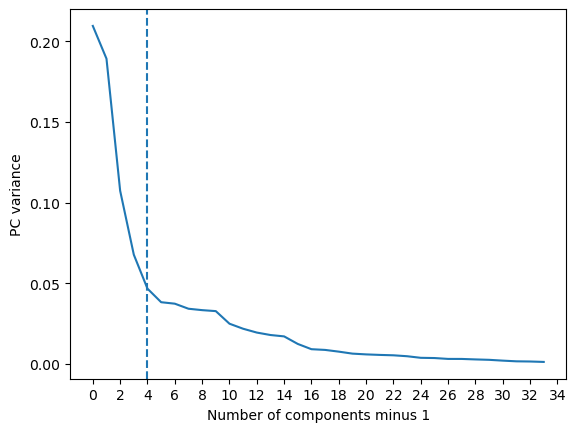

In [63]:
# Replace missing values with mean
#data_zs = data_zs.fillna(data_zs.mean())

# Replace infinite values with maximum finite value
#data_zs = data_zs.replace([np.inf, -np.inf], np.nan)
#data_zs = data_zs.fillna(data_zs.max())

# Perform PCA
pca = PCA(n_components = .99, svd_solver = 'full')
pca.fit(data_zs)
plt.plot(pca.explained_variance_ratio_)
plt.xlabel('Number of components minus 1')
plt.ylabel('PC variance')
plt.xticks(np.arange(0, 36, step=2))
plt.axvline(x=4, linestyle='--')


(0.0, 1.0)

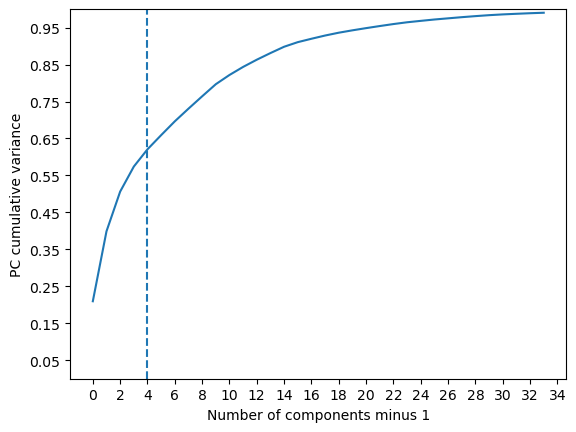

In [64]:
plt.xlabel('Number of components minus 1')
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.ylabel('PC cumulative variance')
plt.yticks(np.arange(0.05, 1.1, step=.1))
plt.xticks(np.arange(0, 36, step=2))
plt.axvline(x=4, linestyle='--')
plt.ylim(0,1)

In [65]:
%%time
#redo PCA keeping the top few PCs
data_zs = data_zs_save.copy()
pca = PCA(n_components = 5, svd_solver = 'full')
princ_comps = pca.fit_transform(data_zs)
pca.n_components_

CPU times: user 4.72 s, sys: 1.87 s, total: 6.58 s
Wall time: 2.97 s


5

In [66]:
print(np.cumsum(pca.explained_variance_ratio_))

[0.20958684 0.3988491  0.50625154 0.57401336 0.62071921]


In [67]:
data_pca = pd.DataFrame(princ_comps, columns = ['PC' + str(i) for i in range(1, pca.n_components_+1)])
data_pca.shape

(1036009, 5)

In [68]:
data_pca.head(5)

,PC1,PC2,PC3,PC4,PC5
0,3.395270,2.195783,-1.444907,-0.413793,0.259565
1,82.832670,64.622978,183.022247,3.582799,-3.503536
2,0.984392,-0.523870,0.745725,-0.431978,0.340261
3,1.415881,-0.159945,1.385428,-0.418964,0.320905
4,2.312201,0.604607,2.697311,-0.376165,0.284812


In [69]:
data_pca.describe()

,PC1,PC2,PC3,PC4,PC5
count,1.036009e+06,1.036009e+06,1.036009e+06,1.036009e+06,1.036009e+06
mean,8.911438e-16,-7.112880e-16,4.893390e-15,-9.347573e-16,-5.741921e-16
std,3.516479e+00,3.341627e+00,2.517289e+00,1.999487e+00,1.660014e+00
min,-3.357871e+02,-1.196676e+00,-6.618023e+02,-1.049372e+02,-2.825307e+02
25%,-6.909123e-02,-4.681162e-01,-4.030261e-01,-1.570318e-01,-1.068250e-01
50%,3.173212e-01,-3.739965e-01,-1.971827e-01,2.220428e-02,7.770453e-02
75%,5.554454e-01,-2.167323e-01,4.111532e-02,1.679567e-01,2.060741e-01
max,1.231969e+03,1.391165e+03,7.525434e+02,1.110263e+03,5.262294e+02


In [70]:
# zscale the pcs. optional step
data_pca_zs = (data_pca - data_pca.mean()) / data_pca.std()
data_pca_zs.describe()

,PC1,PC2,PC3,PC4,PC5
count,1.036009e+06,1.036009e+06,1.036009e+06,1.036009e+06,1.036009e+06
mean,-1.642321e-16,-8.493051e-16,-1.892412e-15,8.154639e-16,-2.070685e-15
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-9.548958e+01,-3.581117e-01,-2.629028e+02,-5.248205e+01,-1.701978e+02
25%,-1.964784e-02,-1.400863e-01,-1.601032e-01,-7.853607e-02,-6.435189e-02
50%,9.023833e-02,-1.119205e-01,-7.833136e-02,1.110499e-02,4.680958e-02
75%,1.579550e-01,-6.485830e-02,1.633318e-02,8.399991e-02,1.241400e-01
max,3.503417e+02,4.163136e+02,2.989499e+02,5.552739e+02,3.170031e+02


In [71]:
data_pca_zs.shape

(1036009, 5)

In [72]:
data_pca_zs.head(5)

,PC1,PC2,PC3,PC4,PC5
0,0.965531,0.657100,-0.573993,-0.206950,0.156363
1,23.555572,19.338775,72.706093,1.791859,-2.110547
2,0.279937,-0.156771,0.296241,-0.216045,0.204975
3,0.402642,-0.047864,0.550365,-0.209536,0.193315
4,0.657533,0.180932,1.071514,-0.188131,0.171572


## Now calculate two unsupervised fraud scores

In [73]:
# Set the powers for the two Minkowski distances
p1 = 2
p2 = 2
ntop = 100

### Calculate score 1

In [74]:
oop1 = 1/p1
score1 = (((data_pca_zs).abs()**p1).sum(axis=1))**oop1
score1.head(10)

0     1.326942
1    78.884056
2     0.528574
3     0.740668
4     1.295399
5     0.465365
6     0.435480
7     0.434560
8     1.042371
9     1.010366
dtype: float64

In [75]:
data_pca_zs.head(10)

,PC1,PC2,PC3,PC4,PC5
0,0.965531,0.657100,-0.573993,-0.206950,0.156363
1,23.555572,19.338775,72.706093,1.791859,-2.110547
2,0.279937,-0.156771,0.296241,-0.216045,0.204975
3,0.402642,-0.047864,0.550365,-0.209536,0.193315
4,0.657533,0.180932,1.071514,-0.188131,0.171572
5,0.055226,-0.319695,-0.126459,-0.211624,0.224797
6,0.162804,-0.254327,0.061143,-0.219382,0.215843
7,0.153332,-0.261565,0.042892,-0.219361,0.216695
8,0.543004,0.079402,0.844200,-0.200882,0.179869
9,0.528802,0.066455,0.814387,-0.201789,0.181232


In [76]:
score1.max()

653.7120158714044

### Autoencoder for score 2

In [77]:
%%time
NNmodel = MLPRegressor(hidden_layer_sizes=(3),activation='logistic',max_iter=50,random_state=1)
NNmodel.fit(data_pca_zs,data_pca_zs)

CPU times: user 4min 37s, sys: 1min 39s, total: 6min 17s
Wall time: 2min 26s


/Users/indiralakshmigundavarapu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPRegressor(activation='logistic', hidden_layer_sizes=3, max_iter=50,
             random_state=1)

In [78]:
# calculate score 2 as the error of an autoencoder
pca_out = NNmodel.predict(data_pca_zs)
error = pca_out - data_pca_zs
oop2 = 1/p2
score2 = ((error.abs()**p2).sum(axis=1))**oop2
score2.max()

652.339294667739

In [79]:
scores = pd.DataFrame(score1)
scores.columns=['score1']
scores['score2'] = score2
scores['RECORD'] = save_record
scores.head(10)

,score1,score2,RECORD
0,1.326942,1.254165,1
1,78.884056,53.501196,2
2,0.528574,0.177379,9
3,0.740668,0.193388,10
4,1.295399,0.237140,11
5,0.465365,0.168135,12
6,0.435480,0.171867,13
7,0.434560,0.171775,14
8,1.042371,0.219813,15
9,1.010366,0.216929,16


In [80]:
scores['score1 rank'] = scores['score1'].rank()
scores['score2 rank'] = scores['score2'].rank()
scores.head(20)

,score1,score2,RECORD,score1 rank,score2 rank
0,1.326942,1.254165,1,983453.0,1022923.0
1,78.884056,53.501196,2,1035948.0,1035941.0
2,0.528574,0.177379,9,843968.0,693869.0
3,0.740668,0.193388,10,925251.0,742954.0
4,1.295399,0.237140,11,982044.0,845966.0
5,0.465365,0.168135,12,790555.0,662640.0
6,0.435480,0.171867,13,743339.0,675230.0
7,0.434560,0.171775,14,741228.0,674939.0
8,1.042371,0.219813,15,965532.0,811293.0
9,1.010366,0.216929,16,962732.0,805027.0


In [81]:
# calculate the final score as the average of the two scores
scores['final'] = (.5*scores['score1 rank'] + .5*scores['score2 rank'])
scores_sorted = scores.sort_values(by='final', ascending=False)
scores.head(20)

,score1,score2,RECORD,score1 rank,score2 rank,final
0,1.326942,1.254165,1,983453.0,1022923.0,1003188.0
1,78.884056,53.501196,2,1035948.0,1035941.0,1035944.5
2,0.528574,0.177379,9,843968.0,693869.0,768918.5
3,0.740668,0.193388,10,925251.0,742954.0,834102.5
4,1.295399,0.237140,11,982044.0,845966.0,914005.0
5,0.465365,0.168135,12,790555.0,662640.0,726597.5
6,0.435480,0.171867,13,743339.0,675230.0,709284.5
7,0.434560,0.171775,14,741228.0,674939.0,708083.5
8,1.042371,0.219813,15,965532.0,811293.0,888412.5
9,1.010366,0.216929,16,962732.0,805027.0,883879.5


In [82]:
scores_sorted.head(10)

,score1,score2,RECORD,score1 rank,score2 rank,final
912153,653.712016,652.339295,956520,1036009.0,1036009.0,1036009.0
569132,604.493524,600.609260,917942,1036008.0,1036008.0,1036008.0
636380,561.319199,559.884412,658933,1036007.0,1036007.0,1036007.0
84007,397.250939,379.567344,67129,1036006.0,1036006.0,1036006.0
967426,309.746949,285.100657,1059883,1036005.0,1036005.0,1036005.0
874785,240.468454,236.338854,915469,1036003.0,1036004.0,1036003.5
648577,254.388254,229.939080,684704,1036004.0,1036003.0,1036003.5
706226,222.331733,221.362085,665158,1036001.0,1036002.0,1036001.5
57959,239.746994,215.125691,139726,1036002.0,1036000.0,1036001.0
303762,219.581344,218.968611,333412,1036000.0,1036001.0,1036000.5


In [83]:
scores_sorted.tail(10)

,score1,score2,RECORD,score1 rank,score2 rank,final
715922,0.133419,0.015467,818888,176.0,3.0,89.5
664034,0.130974,0.020621,860314,164.0,10.0,87.0
408971,0.102419,0.024290,324662,32.0,120.0,76.0
276138,0.121472,0.020862,492696,106.0,12.0,59.0
248984,0.116413,0.021085,282726,84.0,14.0,49.0
978056,0.108248,0.022977,1000137,43.0,46.0,44.5
582234,0.115850,0.014303,615417,82.0,2.0,42.0
246335,0.103554,0.023014,256980,33.0,47.0,40.0
582241,0.071295,0.023230,615424,9.0,56.0,32.5
246401,0.101552,0.020739,257055,30.0,11.0,20.5


In [84]:
scores.describe()

,score1,score2,RECORD,score1 rank,score2 rank,final
count,1.036009e+06,1.036009e+06,1.036009e+06,1.036009e+06,1.036009e+06,1.036009e+06
mean,5.743126e-01,2.133257e-01,5.386169e+05,5.180050e+05,5.180050e+05,5.180050e+05
std,2.161056e+00,1.556582e+00,3.075719e+05,2.990702e+05,2.990702e+05,2.830702e+05
min,4.858499e-02,5.812602e-03,1.000000e+00,1.000000e+00,1.000000e+00,2.050000e+01
25%,2.250234e-01,7.082914e-02,2.753350e+05,2.590035e+05,2.590030e+05,2.652680e+05
50%,3.003512e-01,1.261097e-01,5.412030e+05,5.180050e+05,5.180050e+05,5.249195e+05
75%,4.551001e-01,2.055448e-01,8.036350e+05,7.770070e+05,7.770070e+05,7.508085e+05
max,6.537120e+02,6.523393e+02,1.070994e+06,1.036009e+06,1.036009e+06,1.036009e+06


In [85]:
scores_sorted.describe()

,score1,score2,RECORD,score1 rank,score2 rank,final
count,1.036009e+06,1.036009e+06,1.036009e+06,1.036009e+06,1.036009e+06,1.036009e+06
mean,5.743126e-01,2.133257e-01,5.386169e+05,5.180050e+05,5.180050e+05,5.180050e+05
std,2.161056e+00,1.556582e+00,3.075719e+05,2.990702e+05,2.990702e+05,2.830702e+05
min,4.858499e-02,5.812602e-03,1.000000e+00,1.000000e+00,1.000000e+00,2.050000e+01
25%,2.250234e-01,7.082914e-02,2.753350e+05,2.590035e+05,2.590030e+05,2.652680e+05
50%,3.003512e-01,1.261097e-01,5.412030e+05,5.180050e+05,5.180050e+05,5.249195e+05
75%,4.551001e-01,2.055448e-01,8.036350e+05,7.770070e+05,7.770070e+05,7.508085e+05
max,6.537120e+02,6.523393e+02,1.070994e+06,1.036009e+06,1.036009e+06,1.036009e+06


In [86]:
scores_sorted.set_index('RECORD', drop=True, inplace=True)
scores_sorted.head(10)

,score1,score2,score1 rank,score2 rank,final
RECORD,,,,,
956520,653.712016,652.339295,1036009.0,1036009.0,1036009.0
917942,604.493524,600.609260,1036008.0,1036008.0,1036008.0
658933,561.319199,559.884412,1036007.0,1036007.0,1036007.0
67129,397.250939,379.567344,1036006.0,1036006.0,1036006.0
1059883,309.746949,285.100657,1036005.0,1036005.0,1036005.0
915469,240.468454,236.338854,1036003.0,1036004.0,1036003.5
684704,254.388254,229.939080,1036004.0,1036003.0,1036003.5
665158,222.331733,221.362085,1036001.0,1036002.0,1036001.5
139726,239.746994,215.125691,1036002.0,1036000.0,1036001.0


(0.1, 2052895.9021916825)

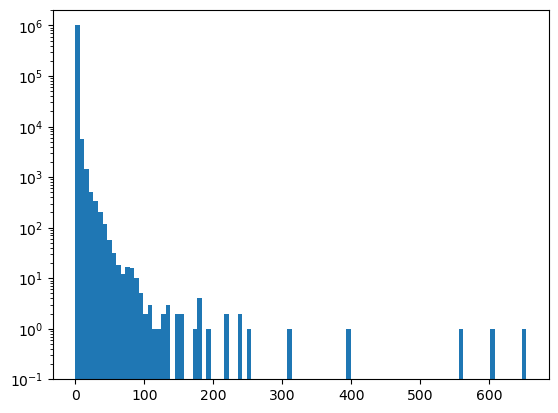

In [87]:
sc1max = int(score1.max())
plt.hist(score1, bins =100, range=(0,sc1max+1))
plt.yscale('log')
plt.ylim(ymin=.1)

In [88]:
sc2max = int(score2.max())
sc2max

652

652


(0.1, 2067959.122897453)

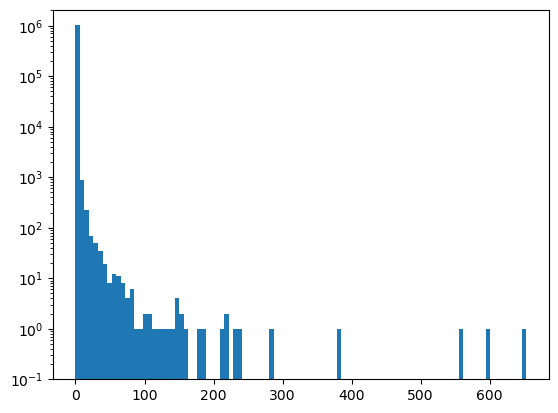

In [89]:
sc2max = int(score2.max())
print(sc2max)
plt.hist(score2, bins =100, range=(0,sc2max+1))
plt.yscale('log')
plt.ylim(ymin=.1)

(array([  867.,  2268.,  4708.,  6870.,  8232.,  8564.,  8788.,  9496.,
         9449., 10254., 10896., 10997., 11695., 12320., 12510., 12327.,
        12451., 12336., 12805., 12581., 12505., 12367., 12140., 12270.,
        12182., 11687., 11454., 11556., 11522., 11616., 11149., 11257.,
        11345., 11198., 10939., 11128., 10899., 10405., 10001.,  9958.,
        10060.,  9748.,  9301.,  9289.,  8968.,  8965.,  8629.,  8784.,
         9559.,  9885., 10301.,  9941.,  9442.,  9800.,  9653.,  9742.,
         9881., 10059., 10356., 10646.,  9846., 10353., 10724., 10244.,
        11423., 13205., 14354., 15337., 16069., 15990., 16170., 15025.,
        15294., 14248., 13776., 13723., 12107., 11318.,  9493.,  8618.,
         8076.,  8110.,  8202.,  7796.,  7881.,  8131.,  8281.,  9179.,
         9834.,  9480.,  9597.,  8713.,  8607.,  8609.,  8256.,  7774.,
         7519.,  7974.,  7024.,  8648.]),
 array([2.05000000e+01, 1.03803850e+04, 2.07402700e+04, 3.11001550e+04,
        4.14600400e+04

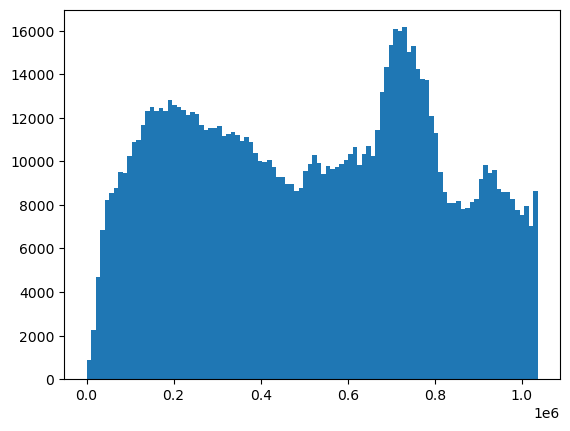

In [90]:
plt.hist(scores['final'],bins=100)

In [91]:
top_records = scores_sorted.head(ntop).index
print(top_records)

Int64Index([ 956520,  917942,  658933,   67129, 1059883,  915469,  684704,
             665158,  139726,  333412,  382398,   12076,  252834,  980276,
             973912,  106681,  665157,  982930,  638993,  330291,   33564,
             288274,  330292,  610682,   95995,   86946,   39770,  151044,
              14979,   47984,  882885,   33751,  918858,   60469,  216948,
             976655,  991517,  621689,  712085,  803040,  643751,  106723,
             994817,  981751,  994813,  994819,  994815,  565397, 1065870,
              56969,  155893,  649717,   48221,    7056,  994821,  817349,
              85962,  992071,  556910,  981883,       2,  845810,  818084,
              41924,   64271,  459429,  807993,    7054,  684926,  684563,
             996722,  579512,  607658,  918187,  104411,  895193,    7043,
               7042,    7039,    7040,    7033,    7038,    7036,    7035,
               7034,    7037,    7041,     428,  691986,  917946,  376108,
             974919, 1053

In [92]:
data_zs['RECORD'] = save_record
data_zs.set_index('RECORD', inplace=True, drop=True)
data_zs.head()

,r1,r2,r3,r4,r5,r6,r7,r8,r9,TOTALACREAGE,...,r1inv_taxclass,r2inv_taxclass,r3inv_taxclass,r4inv_taxclass,r5inv_taxclass,r6inv_taxclass,r7inv_taxclass,r8inv_taxclass,r9inv_taxclass,value_ratio
RECORD,,,,,,,,,,,,,,,,,,,,,
1,-0.334651,2.326051,-0.001721,-0.029165,1.245256,0.217396,-0.038824,1.659088,0.274334,-1.03468,...,-0.200826,-0.067041,-0.065995,-0.522293,-0.368613,-0.532717,-0.333656,-0.239798,-0.375516,0.254459
2,113.628540,23.883470,3.961377,59.485487,4.302972,0.867555,136.936327,15.392241,2.933690,-1.03468,...,-0.214253,-0.067090,-0.066125,-0.544945,-0.368770,-0.533858,-0.358486,-0.239996,-0.376522,0.180261
9,0.356815,0.143396,-0.463082,0.739834,0.156914,-0.041198,0.792266,0.268627,-0.035253,-1.03468,...,-0.212869,-0.066799,-0.063778,-0.542103,-0.367361,-0.502566,-0.355926,-0.238814,-0.358488,0.232966
10,0.700259,0.362992,-0.449469,1.131974,0.242778,-0.035042,1.205060,0.408521,-0.026118,-1.03468,...,-0.213298,-0.066890,-0.064506,-0.542992,-0.367815,-0.512325,-0.356720,-0.239186,-0.364076,0.232966
11,1.658343,0.975587,-0.411495,1.198753,0.257400,-0.033993,2.356605,0.798774,-0.000636,-1.03468,...,-0.213744,-0.066985,-0.065262,-0.543091,-0.367866,-0.513419,-0.357544,-0.239572,-0.369883,0.190866


In [93]:
data_zs_top_n = data_zs.loc[top_records]
data_zs_top_n.transpose()

RECORD,956520,917942,658933,67129,1059883,915469,684704,665158,139726,333412,...,376108,974919,1053859,921816,1023457,987666,773744,995567,184317,174559
r1,-0.115435,0.795658,0.192157,115.910917,202.275020,0.643395,199.333368,-0.398590,252.947435,-0.402384,...,-0.130787,-0.413210,-0.414640,-0.371912,-0.335078,-0.359401,2.469382,-0.414640,-0.414497,-0.330005
r2,-0.349844,46.418710,-0.349833,768.664764,-0.025747,107.550202,-0.268224,88.298027,-0.025747,-0.349834,...,-0.345455,-0.345682,-0.349813,14.249665,25.405028,24.029217,39.594815,-0.349868,-0.349797,25.874814
r3,-0.493634,47.826279,-0.493623,92.833783,-0.291125,166.301360,-0.392472,274.271639,-0.242411,-0.493624,...,-0.486818,-0.489472,-0.493599,44.757784,39.420159,37.287987,61.410872,-0.493658,-0.493561,40.148212
r4,-0.046083,40.937622,0.008162,357.256315,245.843886,0.308505,38.213280,-0.090127,307.340107,-0.103891,...,-0.130431,-0.140803,-0.140999,-0.008392,0.103402,0.034817,4.158238,-0.140995,-0.140973,0.087610
r5,-0.035953,543.560674,-0.035952,809.078483,0.098750,15.662475,-0.030587,96.183960,0.098750,-0.035919,...,-0.035899,-0.035756,-0.035894,15.480495,27.056988,26.536558,20.355641,-0.035952,-0.035950,24.222116
r6,-0.055023,649.525693,-0.055023,113.516350,0.042329,28.012347,-0.047331,344.884209,0.065745,-0.054983,...,-0.054925,-0.054796,-0.054949,55.569969,48.507784,47.574939,36.495939,-0.055022,-0.055019,43.426411
r7,-0.087016,40.213041,-0.037722,139.679572,253.670608,0.034592,14.337178,-0.115673,317.122001,-0.120233,...,-0.107188,-0.134888,-0.134964,-0.083609,-0.039337,-0.068572,3.331412,-0.134963,-0.134955,-0.033240
r8,-0.045605,826.334945,-0.045604,489.855169,0.169510,9.119425,-0.042472,56.427535,0.169510,-0.045585,...,-0.045379,-0.045488,-0.045572,9.255026,16.361550,15.485090,25.401154,-0.045606,-0.045605,16.660827
r9,-0.055769,899.277206,-0.055768,62.569717,0.085819,14.867484,-0.051679,184.319912,0.119874,-0.055747,...,-0.055398,-0.055646,-0.055731,30.309292,26.727587,25.296837,41.484010,-0.055769,-0.055767,27.216133
TOTALACREAGE,1.801988,-0.439711,0.036170,-0.455532,1.676523,-0.204413,0.050637,-0.336529,-1.040111,-0.423008,...,-0.767447,4.162441,1.011790,-0.169653,0.912369,4.162441,-0.826756,0.147025,-0.908247,-0.496154


In [94]:
scores.set_index('RECORD',inplace=True)
scores.drop(columns=['score1','score2'],inplace=True)
scores.head(30)

,score1 rank,score2 rank,final
RECORD,,,
1,983453.0,1022923.0,1003188.0
2,1035948.0,1035941.0,1035944.5
9,843968.0,693869.0,768918.5
10,925251.0,742954.0,834102.5
11,982044.0,845966.0,914005.0
12,790555.0,662640.0,726597.5
13,743339.0,675230.0,709284.5
14,741228.0,674939.0,708083.5
15,965532.0,811293.0,888412.5


In [95]:
# NY_data_with_scores = NY_data_orig.join(scores, on='RECORD', rsuffix='_scores')
NY_data_with_scores = NY_data_orig.join(scores, on='RECORD')
NY_data_with_scores

,RECORD,BBLE,BORO,BLOCK,LOT,EASEMENT,OWNER,BLDGCL,TAXCLASS,LTFRONT,...,AVTOT2,EXLAND2,EXTOT2,EXCD2,PERIOD,YEAR,VALTYPE,score1 rank,score2 rank,final
0,1,1000010101,1,1,101,NaN,U S GOVT LAND & BLDGS,P7,4,500,...,8613000.0,3775500.0,8613000.0,NaN,FINAL,2010/11,AC-TR,983453.0,1022923.0,1003188.0
1,2,1000010201,1,1,201,NaN,U S GOVT LAND & BLDGS,Z9,4,27,...,80690400.0,11111400.0,80690400.0,NaN,FINAL,2010/11,AC-TR,1035948.0,1035941.0,1035944.5
2,3,1000020001,1,2,1,NaN,DEPT OF GENERAL SERVI,Y7,4,709,...,40179510.0,32321790.0,40179510.0,NaN,FINAL,2010/11,AC-TR,NaN,NaN,NaN
3,4,1000020023,1,2,23,NaN,DEPARTMENT OF BUSINES,T2,4,793,...,15750000.0,13644000.0,15750000.0,NaN,FINAL,2010/11,AC-TR,NaN,NaN,NaN
4,5,1000030001,1,3,1,NaN,PARKS AND RECREATION,Q1,4,323,...,107758350.0,106348680.0,107758350.0,NaN,FINAL,2010/11,AC-TR,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1070989,1070990,5080500083,5,8050,83,NaN,"TOBIN, GALE",A1,1,60,...,NaN,NaN,NaN,NaN,FINAL,2010/11,AC-TR,596907.0,390317.0,493612.0
1070990,1070991,5080500086,5,8050,86,NaN,SHERRI MILINAZZO,A1,1,62,...,NaN,NaN,NaN,NaN,FINAL,2010/11,AC-TR,974606.0,814677.0,894641.5
1070991,1070992,5080500089,5,8050,89,NaN,JOHN GERVASI,A1,1,53,...,NaN,NaN,NaN,1017.0,FINAL,2010/11,AC-TR,937586.0,909604.0,923595.0
1070992,1070993,5080500092,5,8050,92,NaN,RITA M MOOG,A1,1,52,...,NaN,NaN,NaN,NaN,FINAL,2010/11,AC-TR,622058.0,685251.0,653654.5


In [96]:
NY_data_scored_and_sorted = NY_data_with_scores.sort_values(by=['final','RECORD'], ascending = [False,True])
NY_data_scored_and_sorted.set_index('RECORD',inplace=True)
NY_data_top_n = NY_data_scored_and_sorted.head(ntop)
NY_data_top_n

,BBLE,BORO,BLOCK,LOT,EASEMENT,OWNER,BLDGCL,TAXCLASS,LTFRONT,LTDEPTH,...,AVTOT2,EXLAND2,EXTOT2,EXCD2,PERIOD,YEAR,VALTYPE,score1 rank,score2 rank,final
RECORD,,,,,,,,,,,,,,,,,,,,,
956520,5006590012,5,659,12,NaN,TROMPETA RIZALINA,A1,1,25,91,...,NaN,NaN,NaN,NaN,FINAL,2010/11,AC-TR,1036009.0,1036009.0,1036009.0
917942,4142600001,4,14260,1,NaN,"LOGAN PROPERTY, INC.",T1,4,4910,0,...,4.501180e+09,1.644454e+09,4.501180e+09,NaN,FINAL,2010/11,AC-TR,1036008.0,1036008.0,1036008.0
658933,4029060054,4,2906,54,NaN,WAN CHIU CHEUNG,C0,1,25,100,...,NaN,NaN,NaN,NaN,FINAL,2010/11,AC-TR,1036007.0,1036007.0,1036007.0
67129,1011110001,1,1111,1,NaN,CULTURAL AFFAIRS,Q1,4,840,0,...,2.465055e+09,2.371005e+09,2.465055e+09,NaN,FINAL,2010/11,AC-TR,1036006.0,1036006.0,1036006.0
1059883,5069770012E,5,6977,12,E,NaN,Z7,4,5,5,...,NaN,NaN,NaN,NaN,FINAL,2010/11,AC-TR,1036005.0,1036005.0,1036005.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
773744,4078800001,4,7880,1,NaN,INDIAN CULTURAL AND C,I1,4,403,309,...,6.773721e+07,NaN,NaN,NaN,FINAL,2010/11,AC-TR,1035871.0,1035938.0,1035904.5
987666,5023900194,5,2390,194,NaN,SI HISTORICAL SOCIETY,P9,4,640,775,...,5.622264e+06,5.616000e+06,5.622264e+06,NaN,FINAL,2010/11,AC-TR,1035870.0,1035939.0,1035904.5
995567,5028730105,5,2873,105,NaN,NaN,Z7,4,100,200,...,NaN,NaN,NaN,NaN,FINAL,2010/11,AC-TR,1035928.0,1035876.0,1035902.0


In [97]:
NY_data_with_scores.head(10)

,RECORD,BBLE,BORO,BLOCK,LOT,EASEMENT,OWNER,BLDGCL,TAXCLASS,LTFRONT,...,AVTOT2,EXLAND2,EXTOT2,EXCD2,PERIOD,YEAR,VALTYPE,score1 rank,score2 rank,final
0,1,1000010101,1,1,101,NaN,U S GOVT LAND & BLDGS,P7,4,500,...,8613000.0,3775500.0,8613000.0,NaN,FINAL,2010/11,AC-TR,983453.0,1022923.0,1003188.0
1,2,1000010201,1,1,201,NaN,U S GOVT LAND & BLDGS,Z9,4,27,...,80690400.0,11111400.0,80690400.0,NaN,FINAL,2010/11,AC-TR,1035948.0,1035941.0,1035944.5
2,3,1000020001,1,2,1,NaN,DEPT OF GENERAL SERVI,Y7,4,709,...,40179510.0,32321790.0,40179510.0,NaN,FINAL,2010/11,AC-TR,NaN,NaN,NaN
3,4,1000020023,1,2,23,NaN,DEPARTMENT OF BUSINES,T2,4,793,...,15750000.0,13644000.0,15750000.0,NaN,FINAL,2010/11,AC-TR,NaN,NaN,NaN
4,5,1000030001,1,3,1,NaN,PARKS AND RECREATION,Q1,4,323,...,107758350.0,106348680.0,107758350.0,NaN,FINAL,2010/11,AC-TR,NaN,NaN,NaN
5,6,1000030002,1,3,2,NaN,PARKS AND RECREATION,Q1,4,496,...,4268700.0,4268700.0,4268700.0,NaN,FINAL,2010/11,AC-TR,NaN,NaN,NaN
6,7,1000030003,1,3,3,NaN,PARKS AND RECREATION,Q1,4,180,...,3546900.0,3546900.0,3546900.0,NaN,FINAL,2010/11,AC-TR,NaN,NaN,NaN
7,8,1000030010,1,3,10,NaN,DEPT RE-CITY OF NY,Z9,4,362,...,11304000.0,9882000.0,11304000.0,NaN,FINAL,2010/11,AC-TR,NaN,NaN,NaN
8,9,1000041001,1,4,1001,NaN,"TRZ HOLDINGS, LLC",R5,4,0,...,2049290.0,NaN,NaN,NaN,FINAL,2010/11,AC-TR,843968.0,693869.0,768918.5
9,10,1000041002,1,4,1002,NaN,"TRZ HOLDINGS, LLC",R5,4,0,...,2961617.0,NaN,NaN,NaN,FINAL,2010/11,AC-TR,925251.0,742954.0,834102.5


In [98]:
NY_data_top_n['OWNER'].head(40)

RECORD
956520         TROMPETA RIZALINA
917942      LOGAN PROPERTY, INC.
658933           WAN CHIU CHEUNG
67129           CULTURAL AFFAIRS
1059883                      NaN
684704                  W RUFERT
915469     UNITED STATES OF AMER
665158         ST JOHNS CEMETERY
139726     BRADHURST EQUITIES, L
333412            SPOONER ALSTON
382398            MARINO FRANK R
12076      15 WORTH STREET PROPE
252834                       NaN
980276     WOODMONT WEST HOA INC
973912        THE PORT OFNY & NJ
106681           79TH REALTY LLC
665157         ST JOHNS CEMETERY
982930     FOREST VIEW HOMEOWNER
638993     ALEXANDER'S OF REGOPA
330291           PRATT INSTITUTE
33564        HLP PROPERTIES, LLC
288274                       NaN
330292           PRATT INSTITUTE
610682            DEBORAH WILSON
95995        BERGAMINI, JENNIFER
39770      GREENHORN DEVELOPMENT
86946       712 FIFTH AVENUE L P
151044                       NaN
14979           ENJAY ASSOCIATES
47984      BERKOWTIZ, ULWT LOUIS
882

In [99]:
NY_data_top_n.shape

(100, 34)

In [100]:
data_zs_top_n.shape

(100, 59)

In [101]:
NY_top_with_zs = pd.concat([NY_data_top_n,data_zs_top_n],axis=1)
NY_top_with_zs.shape

(100, 93)

In [102]:
NY_top_with_zs.to_excel('NY_top_no_zs.xlsx', index=True)
NY_data_top_n.to_excel('NY_top.xlsx', index=True)
data_zs_top_n.to_csv('data_zs_top.csv', index=True)

In [103]:
data_zs_top_n.shape

(100, 59)

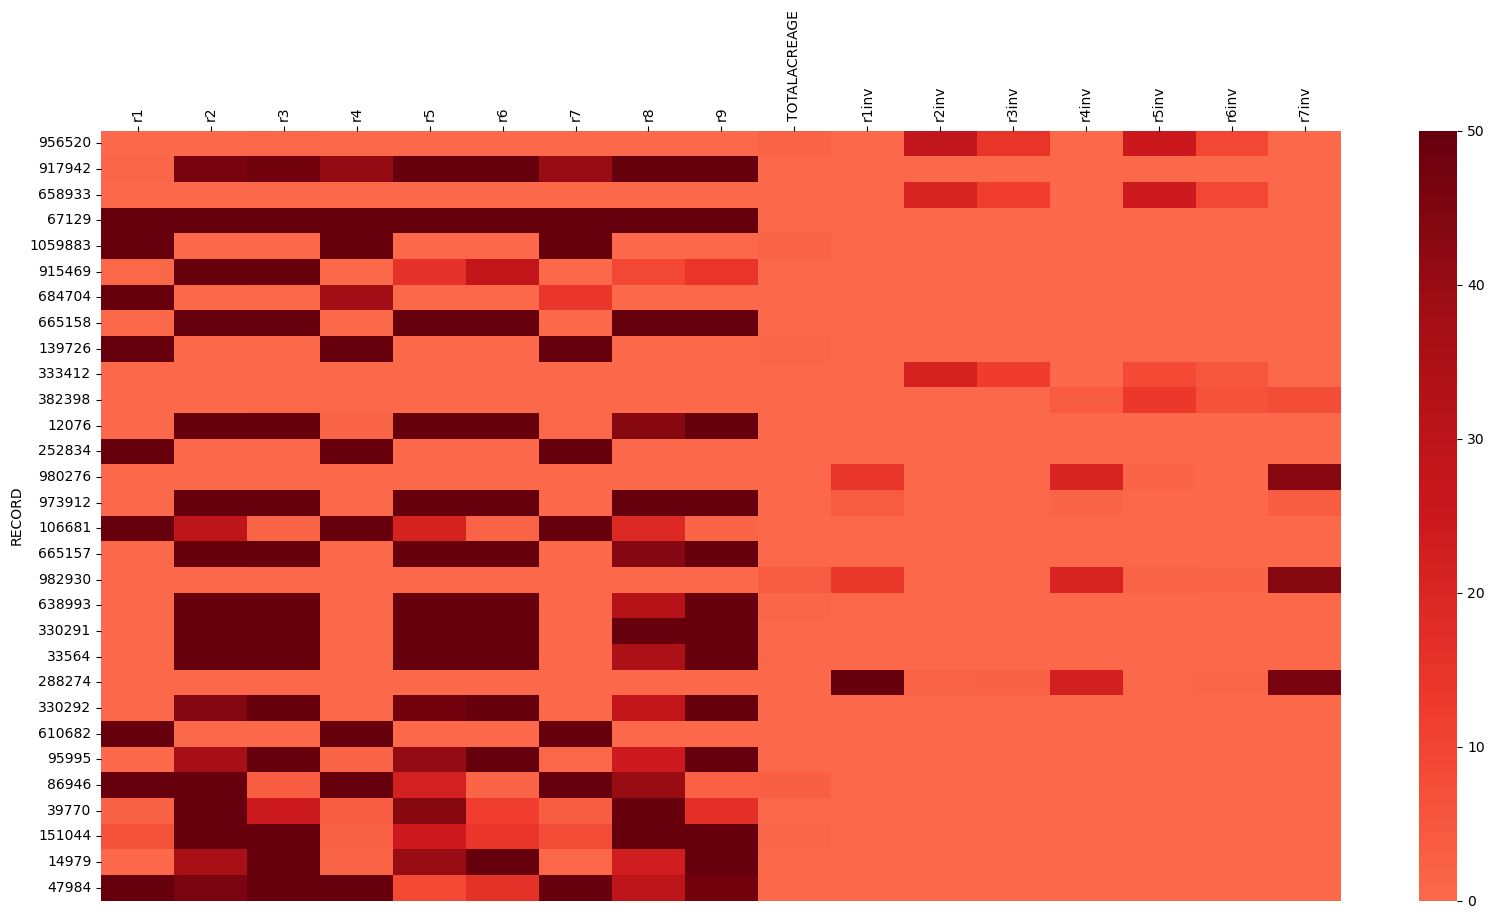

In [104]:
# heatmaps to understand which variables are driving the high scores
data_base_vars = data_zs_top_n.iloc[:,0:17].abs()
data_heatmap = data_base_vars.head(30)
plt.rcParams['figure.figsize'] = (20,10)
ax = sns.heatmap(data_heatmap, center=0, vmin=0, vmax=50, cmap='Reds')
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')
plt.xticks(rotation=90)
plt.savefig('heatmap.png')

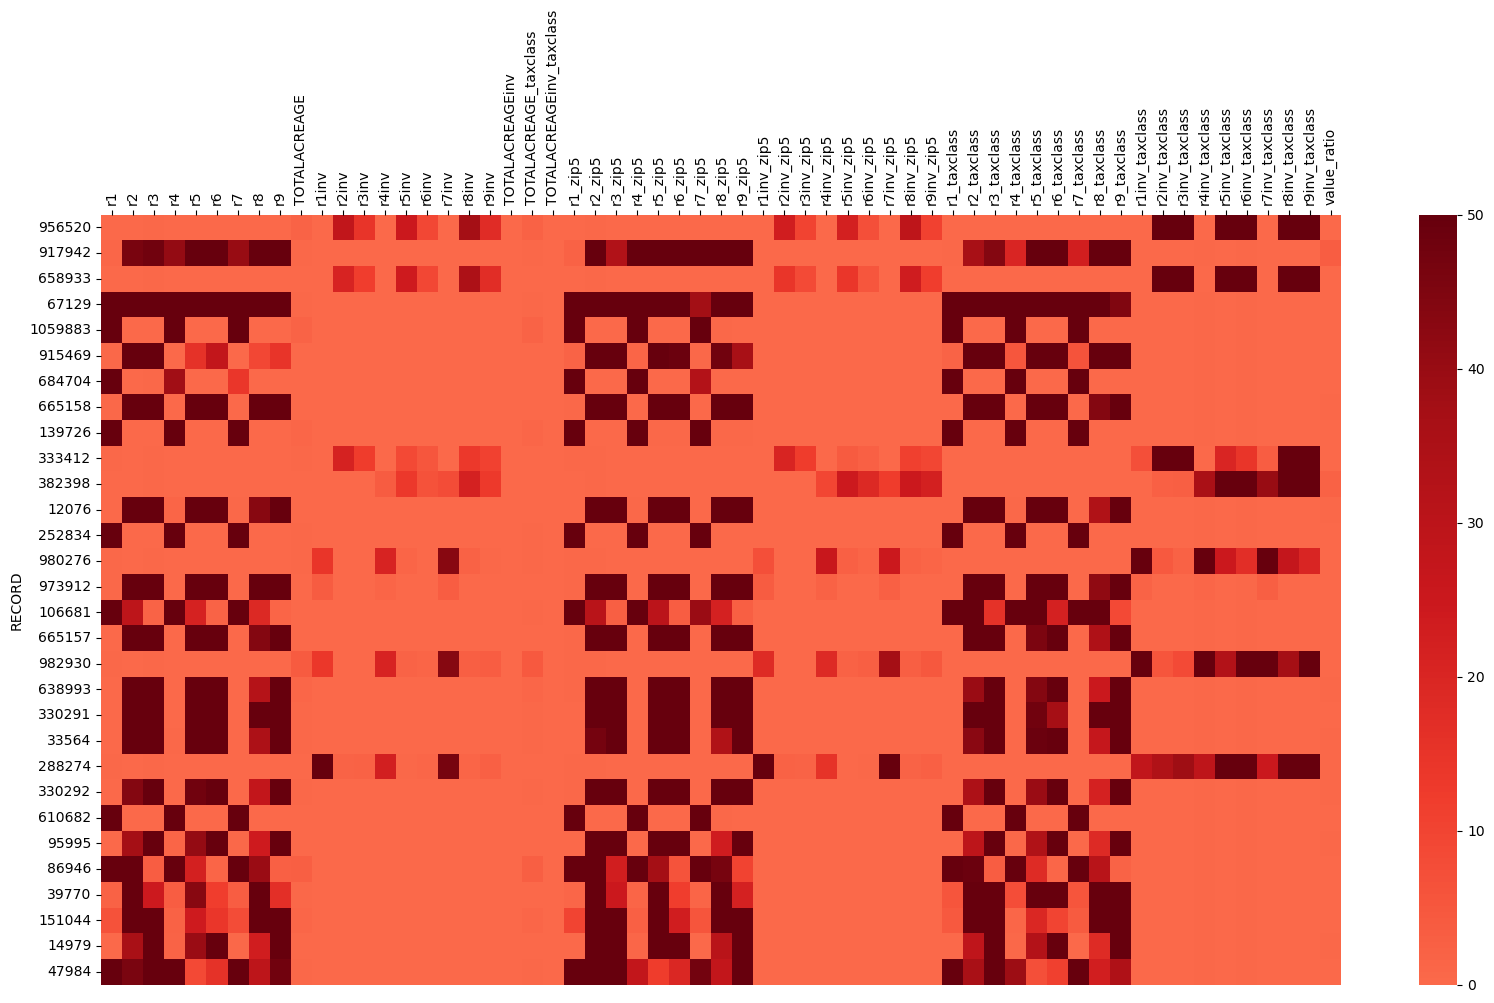

In [105]:
data_zs_top_n_abs = data_zs_top_n.abs()
data_heatmap = data_zs_top_n.abs().head(30)
plt.rcParams['figure.figsize'] = (20,10)
ax = sns.heatmap(data_heatmap, center=0, vmin=0, vmax=50, cmap='Reds')
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')
plt.xticks(rotation=90)
plt.savefig('heatmap.png')

In [106]:
top_records_df = pd.DataFrame(top_records)

In [107]:
#to write out the top n record numbers
top_records_df.to_csv('top_n_record_numbers1.csv', index=False)

In [108]:
#to compare to a previous top n record numbers.

top_records_previous = pd.read_csv('top_n_record_numbers1.csv')
print(top_records_df.head())
print(top_records_previous.head())
num_common = len(pd.merge(top_records_df,top_records_previous, on='RECORD'))
percent_common = 100*num_common/ntop
percent_common

    RECORD
0   956520
1   917942
2   658933
3    67129
4  1059883
    RECORD
0   956520
1   917942
2   658933
3    67129
4  1059883


100.0

In [109]:
print('Duration: ', datetime.now() - start_time)

Duration:  0:06:09.122288
